In [1]:
# Import the necessary libraries
import numpy as np
import random
from collections import deque
import gym
import matplotlib.pyplot as plt

# Import TensorFlow and Keras for building the neural network
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


In [2]:
from tensorflow.keras import Input  

def build_q_network(state_size, action_size):
    """
    Builds a simple MLP using the modern Keras Input layer syntax.
    
    Parameters:
        state_size (int): Dimension of input state space
        action_size (int): Number of possible actions

    Returns:
        model: Compiled Keras model
    """
    model = Sequential([
        Input(shape=(state_size,)),             # Modern Input layer usage
        Dense(24, activation='relu'),
        Dense(24, activation='relu'),
        Dense(action_size, activation='linear')  # Linear output for Q-values
    ])
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model



In [3]:
#Define the DQN Agent with Double DQN and Experience Replay
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size  # e.g., 4 for CartPole
        self.action_size = action_size  # e.g., 2 actions: left or right
        self.memory = deque(maxlen=2000)  # Experience replay buffer
        self.gamma = 0.99  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01  # Minimum epsilon
        self.epsilon_decay = 0.995  # Decay rate for epsilon
        self.batch_size = 64  # Mini-batch size
        self.train_start = 1000  # Start training only after this many experiences

        # Build two models: policy network (used to choose actions) and target network (used to calculate Q-values)
        self.model = build_q_network(state_size, action_size)
        self.target_model = build_q_network(state_size, action_size)
        self.update_target_model()  # Synchronize target model initially

    def update_target_model(self):
        """Copy weights from policy model to target model"""
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """Store the experience in replay buffer"""
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """Choose action using epsilon-greedy policy"""
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Explore
        q_values = self.model.predict(state, verbose=0)  # Exploit
        return np.argmax(q_values[0])  # Return action with highest Q-value

    def replay(self):
        """Train the policy network using a random batch from replay memory"""
        if len(self.memory) < self.train_start:
            return

        minibatch = random.sample(self.memory, self.batch_size)

        states = np.zeros((self.batch_size, self.state_size))
        next_states = np.zeros((self.batch_size, self.state_size))
        actions, rewards, dones = [], [], []

        for i in range(self.batch_size):
            states[i] = minibatch[i][0]
            actions.append(minibatch[i][1])
            rewards.append(minibatch[i][2])
            next_states[i] = minibatch[i][3]
            dones.append(minibatch[i][4])

        # Predict Q-values for next states using policy network and target network (Double DQN)
        target = self.model.predict(states, verbose=0)
        target_next = self.model.predict(next_states, verbose=0)
        target_val = self.target_model.predict(next_states, verbose=0)

        for i in range(self.batch_size):
            if dones[i]:
                target[i][actions[i]] = rewards[i]
            else:
                # Double DQN: use policy model to get best action, use target model to evaluate it
                best_action = np.argmax(target_next[i])
                target[i][actions[i]] = rewards[i] + self.gamma * target_val[i][best_action]

        # Train the model
        self.model.fit(states, target, batch_size=self.batch_size, verbose=0)

        # Decay epsilon after each training step
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [ ]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = DQNAgent(state_size, action_size)

episodes = 1000
target_update_interval = 100  # Update target network every 100 episodes
scores, avg_scores = [], []

for e in range(episodes):
    state, _ = env.reset()  # ✅ Updated to match Gym API
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    done = False

    while not done:
        action = agent.act(state)  # Choose action using epsilon-greedy
        next_state, reward, terminated, truncated, _ = env.step(action)  # ✅ Updated to unpack properly
        done = terminated or truncated  # ✅ Combine termination conditions
        next_state = np.reshape(next_state, [1, state_size])

        agent.remember(state, action, reward, next_state, done)  # Store experience
        state = next_state
        total_reward += reward

        agent.replay()  # Train agent if ready

    scores.append(total_reward)
    avg_score = np.mean(scores[-100:])
    avg_scores.append(avg_score)

    if e % target_update_interval == 0:
        agent.update_target_model()

    print(f"Episode {e+1}, Reward: {total_reward}, Avg(100): {avg_score:.2f}, Epsilon: {agent.epsilon:.3f}")


Episode 1, Reward: 11.0, Avg(100): 11.00, Epsilon: 1.000
Episode 2, Reward: 38.0, Avg(100): 24.50, Epsilon: 1.000
Episode 3, Reward: 11.0, Avg(100): 20.00, Epsilon: 1.000
Episode 4, Reward: 49.0, Avg(100): 27.25, Epsilon: 1.000
Episode 5, Reward: 17.0, Avg(100): 25.20, Epsilon: 1.000
Episode 6, Reward: 14.0, Avg(100): 23.33, Epsilon: 1.000
Episode 7, Reward: 10.0, Avg(100): 21.43, Epsilon: 1.000
Episode 8, Reward: 26.0, Avg(100): 22.00, Epsilon: 1.000
Episode 9, Reward: 11.0, Avg(100): 20.78, Epsilon: 1.000
Episode 10, Reward: 17.0, Avg(100): 20.40, Epsilon: 1.000
Episode 11, Reward: 17.0, Avg(100): 20.09, Epsilon: 1.000
Episode 12, Reward: 12.0, Avg(100): 19.42, Epsilon: 1.000
Episode 13, Reward: 29.0, Avg(100): 20.15, Epsilon: 1.000
Episode 14, Reward: 11.0, Avg(100): 19.50, Epsilon: 1.000
Episode 15, Reward: 17.0, Avg(100): 19.33, Epsilon: 1.000
Episode 16, Reward: 34.0, Avg(100): 20.25, Epsilon: 1.000
Episode 17, Reward: 17.0, Avg(100): 20.06, Epsilon: 1.000
Episode 18, Reward: 30.

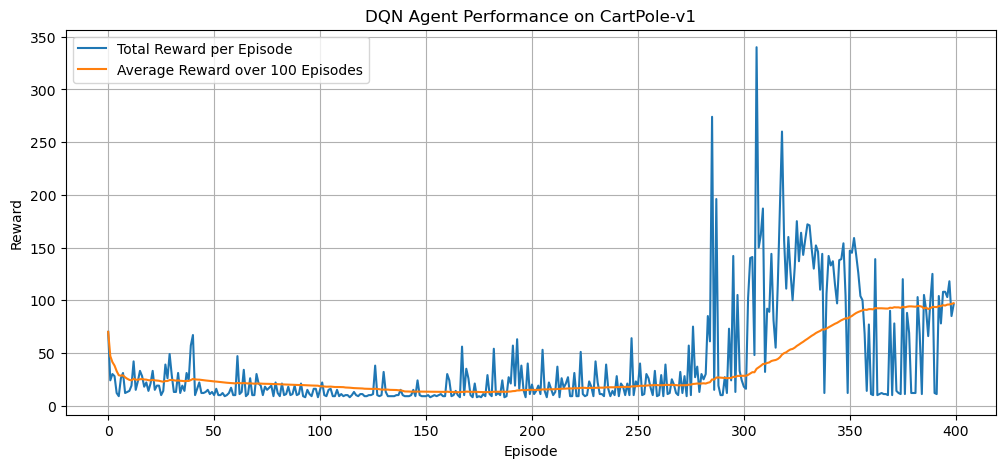

In [5]:
# Plot total rewards and average rewards
plt.figure(figsize=(12, 5))
plt.plot(scores, label='Total Reward per Episode')
plt.plot(avg_scores, label='Average Reward over 100 Episodes')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DQN Agent Performance on CartPole-v1')
plt.legend()
plt.grid()
plt.show()

